In recent decades air pollution has taken a center stage in national and world politics due to the detrimental effect it has on local environment, public health, and global atmosphere quality (in terms of heat retention, UV protection, etc.). It is not surprising then that a significant effort has been expended trying to develop mathematical models that are capable of:

1.	Monitoring or predicting the diffusion of pollutants away from sources and especially near high population centers. These often have the dual purpose of locating erroneous or illegal sources of airborne pollutants.

2.	Projecting the effects of public policies on air quality in short and long time periods.

3.	Forecasting long term effects of rising pollution levels on the atmosphere, local environments, and public health.

4.	Modeling short-term (< 1 month) projections of air quality at high accuracy using meteorological predictions.

This fourth purpose is the focus of this project. Since the advent of big data and machine learning, aided by advancing satellite imagery, meteorological forecasting has improved dramatically in the past two decades. This also provides new opportunities for high-accuracy air quality models. As technology that is capable of actively removing pollutants from the atmosphere improves, these will be able to inform decisions and costs relating to these technologies and help avert public health crises arising from extreme pollutant levels. Even now, these can serve the same purpose in areas like Beijing China, which have experienced such crises already and have had to implement emergency pollutant rationing. These crises could have been averted or lessened using an accurate model capable of predicting extreme pollution levels using meteorological predictions.

A subsequent project on machine learning will present much better opportunities to fully address this question and will come closer to matching contemporary research. In this current project I have fully prepared the data necessary for that project and have implemented a simple OLS regression that can predict air quality using meteorological conditions and previous pollutant levels. This model uses the same factors that will be used in the full model, but these are restricted to a single location where the model developed next semester will be capable of the same feat over a large geographic region.

The data used comes from a database of hourly, daily, and annual summary data from the national network of meteorological and air quality monitoring stations. This was made publicly available by the Clean Air Act in 1990 and is freely distributed on epa.gov. The following function, available in the accompanying project_utils.py file, is capable of downloading and storing any table found on https://aqs.epa.gov/aqsweb/airdata/download_files.html. It also concatenates loaded tables containing the same information, breaks up tables that contain multiple measurements, drops unwanted columns, prints the units of measure for each table, and thereafter returns a dictionary of the desired pandas DataFrames.


In [1]:
import pandas as pd
import numpy as np
import os.path
from matplotlib import pyplot as plt
import datetime

import warnings
warnings.filterwarnings('ignore')

# imports the functions written in previous submissions of this project for use here
import project_utils as utils

In [2]:
tables = utils.fetch_tables(years=['2017'], verbose=False, gpd_bool=False)

Units of measure:
    Ozone: {'Ozone'}  |  {'Parts per million'} 

    SO2: {'Sulfur dioxide'}  |  {'Parts per billion'} 

    CO: {'Carbon monoxide'}  |  {'Parts per million'} 

    NO2: {'Nitrogen dioxide (NO2)'}  |  {'Parts per billion'} 

    Wind_Wind Direction - Resultant: {'Wind Direction - Resultant'}  |  {'Degrees Compass'} 

    Wind_Wind Speed - Resultant: {'Wind Speed - Resultant'}  |  {'Knots'} 

    Temp: {'Outdoor Temperature'}  |  {'Degrees Fahrenheit'} 

    Pressure: {'Barometric pressure'}  |  {'Millibars'} 

    Dewpoint_Relative Humidity : {'Relative Humidity '}  |  {'Percent relative humidity'} 

    Dewpoint_Dew Point: {'Dew Point'}  |  {'Degrees Fahrenheit'} 

    PM2.5 Mass: {'PM2.5 - Local Conditions'}  |  {'Micrograms/cubic meter (LC)'} 

    PM10 Mass: {'PM10 Total 0-10um STP'}  |  {'Micrograms/cubic meter (25 C)'} 



## Data Cleaning

Fortunately, the data found on the EPA website is already exceptionally clean. There was not a single missing value in any column needed except air quality index, hereafter referred to as AQI. However, nearly half of the AQI column was missing for several important pollutants, such as sulfur dioxide and carbon monoxide. This is an extremely important variable because its scale and meaning in terms of health impact is uniform across all pollutants. Fortunately, the function used to relate each pollutant to AQI is well defined. The equation and table below (source https://en.wikipedia.org/wiki/Air_quality_index) compose the piecewise linear function that relates concentration (C) to AQI for several pollutants. It also displays the color-coded health risk level for given ranges of concentration. This equation was used in the function fill_AQI() to fill in NaN values in this column. All measurements were already in the correct units displayed in the table.

![AQI formula](AQI_formula.png)

![AQI table](AQI_table.png)


In [3]:
utils.fill_AQI(tables,'AQI_new')

## Data Visualization

While the data tables provided on EPA.gov are exceptionally clean, they are unfortunately not entirely sufficient for building a regressive model to predict air quality. The most immediate issue arises from the inconsistent density of measurement stations for different variables. For example, consider the charts shown below showing the distribution of monitoring stations for wind speed, temperature, and ozone concentration. It may be the case that one monitoring station could have all variables needed, and that would be sufficient to build an OLS regression for that one location. However, in order to build a geographical model, it is necessary to be able to sample all variables at arbitrary locations. 

![distribution of ozone sampling stations](distribution_ozone.png)

![distribution of wind speed sampling stations](distribution_wind_speed.png)

Several means to accomplish arbitrary sampling were considered, such as drawing values from the nearest neighbor, averaging the k nearest neighbors, or averaging all samples within a minimum specified distance. However, it became apparent that a simple 2D linear interpolation would be the most elegant and efficient method to accomplish sampling at arbitrary locations. Given a region of interest, a list of days, and a list of variables, the function region_2D_interp() generates an interpolating function for each variable on each day listed. These functions are defined over the convex hull of the data points within the region of interest. These can subsequently be used to generate tables filled with samples for each variable at arbitrary locations within the region.

These interpolating functions obviously aren’t valid in every region, as the sampling stations for some variables are quite sparse in several parts of the country. However, there are several regions which are quite smooth for all variables, notably Southern California. The following plots display these functions across the continental US for several variables on July 1, 2017. Some animations of the year 2017 are also available at https://drive.google.com/open?id=1j8nX7w4Y6QLT8RkS_W45qELSPjuWTIO8.

Note that a wildfire that occured in Southern California in late June 2017 is clearly visible on the PM2.5 particulate mass graph. In the animation generated for 2017 it is clear that high mass particulate counts, such as PM2.5 and PM10, are not common and occur mainly during events such as wildfires.

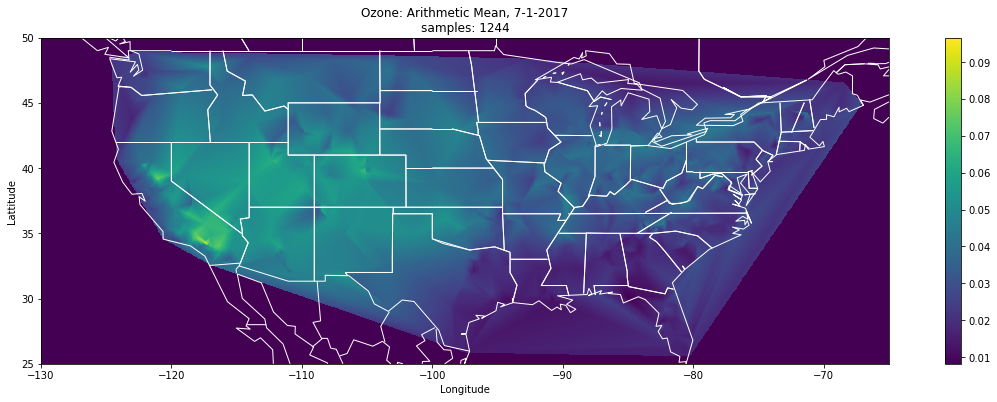

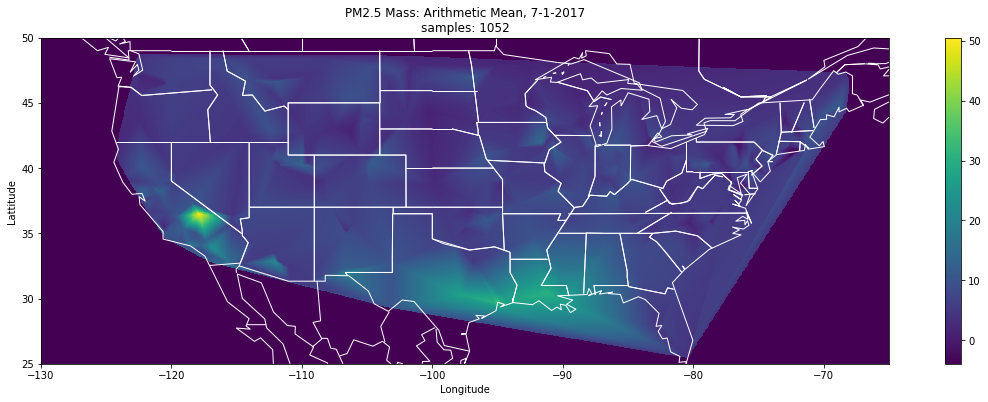

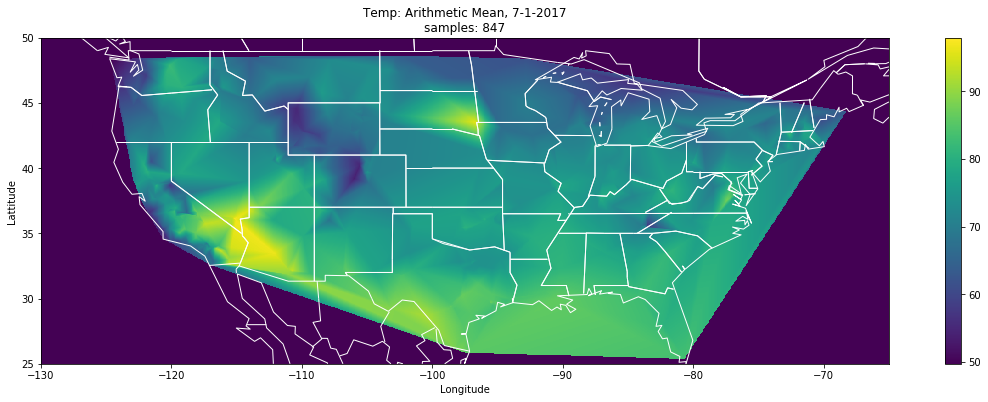

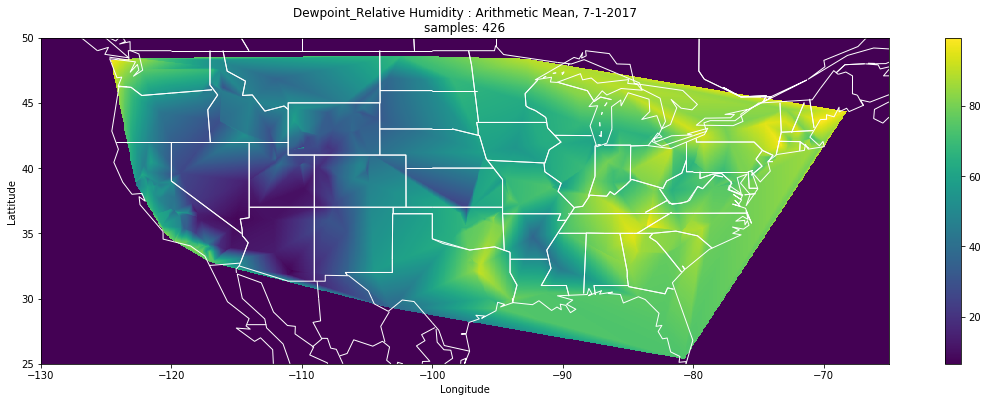

In [4]:
dates1 = [datetime.date(2017,7,1)]

# These plots have the colorscale defined only over values
# found on that actual day for clarity.
utils.region_2D_interp(tables, keys=['Ozone','PM2.5 Mass','Temp',
                                     'Dewpoint_Relative Humidity '],
                 dates=dates1, return_bool=False, abs_min_max=False)

These plots and animations proved efficacious in helping to identify erroneous data points and even a station that reported pressure in incorrect units for a period in 2017. The code directly below deletes the incorrect data points in pressure and generates a sample animation using the function animate_region() function in the project_utils.py file.

In [4]:
# Drop nonsensical values in Pressure table 
# Note 1000 milibars is the normal pressure at sea level. 
# One particular station in Washington State consistently reports values 
# of several thousand milibars
tables['Pressure'] = tables['Pressure'][tables['Pressure']['Arithmetic Mean']<1500]
tables['Pressure'] = tables['Pressure'][tables['Pressure']['Arithmetic Mean']>100]

In [8]:
table_key = 'Dewpoint_Relative Humidity '
var_key = 'Arithmetic Mean'
dates = np.arange(datetime.datetime(2017,1,1), datetime.datetime(2017,12,31), 
                  datetime.timedelta(days=1)).astype(datetime.datetime)

value_min = np.min(tables[table_key][var_key])
value_max = np.max(tables[table_key][var_key])

utils.animate_region(tables, table_key, var_key, dates, value_min, value_max, 
               longitude_bounds=(-130, -65), latitude_bounds=(25, 50), 
               M=1000, N=1000, cmap='viridis', filename='Humidity_2017.mp4')

Generating animation


Below, the same function, region_2D_interp, is used to generate plots of Ozone and Temperature in the Los Angeles area. Observe how the interpolating functions are quite smooth in this region even when zoomed in. The straight lines radiating outward are common in densely populated areas, especially where population is bounded in a small area such as in the Salt Lake Valley. These occur because the density of sampling stations drops very quickly outside populated areas and they are often extremely visible because the highest gradients in pollutant levels are also found at the boundaries of populated areas.

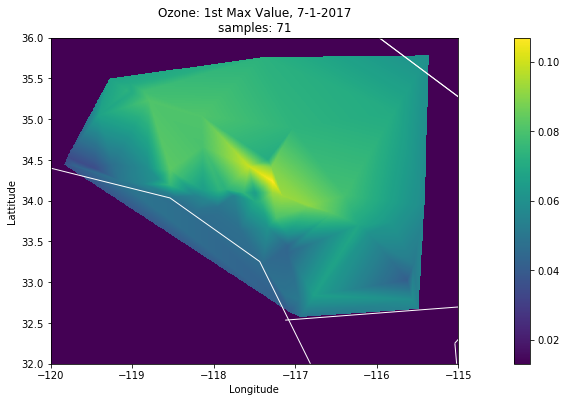

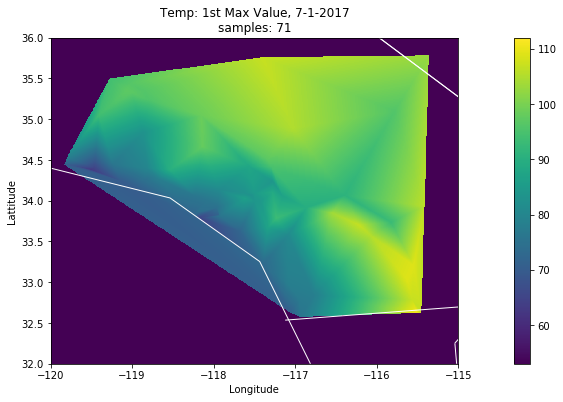

In [7]:
#Region around Los Angeles
longitude_bounds=(-120, -115)
latitude_bounds=(32, 36)
region_2D_interp(tables, keys=['Ozone','Temp'], value_keys=['1st Max Value'], 
                 dates=dates1, return_bool=False, abs_min_max=False,
                longitude_bounds=longitude_bounds,
                latitude_bounds=latitude_bounds)


##  Regression

Since the interpolating functions for each variable appear relatively smooth in the region around Los Angeles shown above, it seems reasonable to generate training data at points within this region. The code is not included here, but several OLS models were trained on data generated for a location in the heart of Los Angeles over a period of one year. Significantly more unique samples, up to 10,000, could have been generated simply by using all data available since 1990. However, generating so many interpolating functions, the number of days times the number of features included, would have been prohibitively expensive. 

Initial models for each pollutant, trained exclusively on the data points generated by the interpolating functions shown above, were not very accurate, showing R squared values as low as .2. Adding a few small features, such as a one-hot encoded season variable, and putting the wind direction through a sine and cosine function as two new columns significantly improved the R squared value. One model showed an improvment in R squared value of .1 just from adding the sine and cosine functions of wind. However, it became quickly apparent that day-of weather conditions are not sufficient to predict pollutant levels. The modified wind direction and maximum humidity levels, however, were often extremely important, as might be expected, since rain can significantly reduce pollution levels, and the direction the wind comes from could be extremely important in a coastal city.

The best models created involved the above engineered features, and several time-averaged or period maximum data points. Specifically, for all maximum variables, such as maximum daily humidity, the maximum value was taken over a period of 3, 7, and 14 days prior and added to the model. The mean was taken over the same periods for mean daily values. Finally, the level of the pollutant being predicted 14 days earlier was added to the model. These models achieved R squared values of up to .9, which is significantly better than both previous models.

## Conclusion
The main achievement of this project is preparing a method by which reasonable data can be generated for a more complex machine learning or deep learning model. Additionally, while linear models lack the capacity to generate a truly useful meteorological model of pollution levels, it has demonstrated that it is possible to effectively model pollution levels for a single location as a function of meteorological data. This is strongly indicitive that a larger model which can use data points across a geographical region, should achieve a minimum of the same performance provided enough data.

A number of things must be done before it is feasible to generate as much data as will be needed next semester. The bottleneck in this code is generating the interpolating functions. In this model each function was used only once, since only one datapoint was generated inside the region per day. This will not be the case next semester, which will improve efficiency. However, it will also help to optimize the code and to save the functions out of the notebook as they are made. With these improvements I believe it will be entirely feasible to create a useful, and accurate, meteorological model of air pollution.